# TechNova Attrition Analysis - Prédisez et comprenez le turnover des employés.

<div align="left">
  <img src="../docs/images/logo_technova.png" width="200px" alt="Logo TechNova Partners">
</div>

## **Objectif**: Identifier les causes racines de l'attrition et prédire le départ des collaborateurs à l'aide de **SHAP**.

# <span style="color:red"> 🏷️ Étape 5 : Optimisez et interprétez le comportement du modèle</span>

Effectivement, c’est ce modèle qui nous servira à <span style="color:red">extraire des causes potentielles de démission</span>. Pour cela, tu utiliseras le package SHAP, mais uniquement après avoir stabilisé ton approche de modélisation !

# ⬇️ IMPORTATION DES LIBRAIRIES (STACK DE SCIENCE DES DONNÉES)

In [1]:
import joblib
import pandas             as pd               # Analyse et structures de données
from pathlib              import Path         # Manipulation moderne de chemins
import numpy              as np               # Algèbre linéaire et tableaux

import shap
from shap import (
    TreeExplainer,
    KernelExplainer,
    DeepExplainer,
    GradientExplainer,
    ExactExplainer,
)
from sklearn.metrics      import (
    roc_curve,                                # Points de la courbe ROC

    confusion_matrix,                         # Matrice d'erreurs de prédiction
    auc,                                      # Calcul de l'aire sous la courbe
    precision_recall_curve,                   # Points de la courbe PR
    average_precision_score,                  # Moyenne de précision (AP)

)


# ⚙️ CONFIGURATION GLOBALE DU PROJET

In [2]:
# Configuration des chemins
RAW_DATA_DIR     = Path("../data/raw")
INTERIM_DATA_DIR = Path("../data/interim")
PREPROCESED_DIR  = Path("../data/processed")
REPORTS_DIR      = Path("../reports")
MODELS_DIR       = Path("../models/V2")                # Use a folder for each Version 


MODEL_DummyClassifier              = 'Baseline_Dummy'
MODEL_LogisticRegression           = 'LogisticReg_Balanced'
MODEL_RandomForestClassifier       = 'RandomForest_Balanced'
MODEL_GradientBoostingClassifier   = 'GradientBoosting'
MODEL_XGBClassifier                = 'XGBoost_Scaled'
MODEL_RandomForestClassifier_SMOTE = 'RF_SMOTE'


# ============================================================================
# CONFIGURATION GLOBALE DU PROJET
# ============================================================================

# Définition de la variable cible du projet (Target)
FEATURE_TARGET           = "attrition_binary"
FEATURE_TARGET_INITIAL   = "a_quitte_l_entreprise"

# 1. Supprimer la limite de largeur de la console (définie à None)
pd.set_option('display.expand_frame_repr', False)

# 2. S’assurer que la largeur des colonnes est suffisante pour les noms longs
pd.set_option('display.max_colwidth', None)

# 3. (Optionnel) Si il y a beaucoup de lignes, on peut contrôler combien en afficher
pd.set_option('display.max_rows', 100)

# ----------------------------------------------------------------------------
# RAPPORT DE CONFIGURATION
# ----------------------------------------------------------------------------
print("\n============================================================================")
print("PARAMÈTRES DE CONFIGURATION INITIALISÉS")
print("============================================================================")
print(f"  Variable cible (Target)...........: {FEATURE_TARGET}")
print(f"  Variable cible iniital (Target)...: {FEATURE_TARGET_INITIAL}")
print("  Status............................: ✅ Configuration prête")
print("============================================================================")



PARAMÈTRES DE CONFIGURATION INITIALISÉS
  Variable cible (Target)...........: attrition_binary
  Variable cible iniital (Target)...: a_quitte_l_entreprise
  Status............................: ✅ Configuration prête


## ❇️ LOAD AND EXPLORE DATASET FINAL

In [3]:
# 1. Chargement des fichiers
input_path = PREPROCESED_DIR / "data_final.csv"
df_final    = pd.read_csv(input_path )
print(df_final.info())                                       # Vérification des types Dtype (int, float, object)
display(df_final.head(3))   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 44 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   n_log__revenu_mensuel                             1470 non-null   float64
 1   n_log__annee_experience_totale                    1470 non-null   float64
 2   n_log__annees_dans_l_entreprise                   1470 non-null   float64
 3   n_log__annees_depuis_la_derniere_promotion        1470 non-null   float64
 4   n_std__age                                        1470 non-null   float64
 5   n_std__nombre_experiences_precedentes             1470 non-null   float64
 6   n_std__annees_dans_le_poste_actuel                1470 non-null   float64
 7   n_std__satisfaction_employee_environnement        1470 non-null   float64
 8   n_std__note_evaluation_precedente                 1470 non-null   float64
 9   n_std__satisfaction

,n_log__revenu_mensuel,n_log__annee_experience_totale,n_log__annees_dans_l_entreprise,n_log__annees_depuis_la_derniere_promotion,n_std__age,n_std__nombre_experiences_precedentes,n_std__annees_dans_le_poste_actuel,n_std__satisfaction_employee_environnement,n_std__note_evaluation_precedente,n_std__satisfaction_employee_nature_travail,...,c_ohe__domaine_etude_Autre,c_ohe__domaine_etude_Entrepreunariat,c_ohe__domaine_etude_Infra & Cloud,c_ohe__domaine_etude_Marketing,c_ohe__domaine_etude_Ressources Humaines,c_ohe__domaine_etude_Transformation Digitale,c_ohe__frequence_deplacement_Aucun,c_ohe__frequence_deplacement_Frequent,c_ohe__frequence_deplacement_Occasionnel,attrition_binary
0,0.218262,-0.148970,0.178857,-0.974295,0.446350,2.125136,-0.063296,-0.660531,0.379672,1.153254,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,-0.017266,0.144921,0.777704,-0.116765,1.322365,-0.678049,0.764998,0.254625,-1.026167,-0.660853,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,-1.377263,-0.321469,-2.399329,-0.974295,0.008343,1.324226,-1.167687,1.169781,-1.026167,0.246200,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


## ⬇️ Import Classe auxiliare pour modelisation (ClassificationModeler)

In [4]:
# ==================================================================================================
# INITIALISATION DU MOTEUR DE NETTOYAGE (DATA CLEANING)
# ==================================================================================================

# Importation de la classe personnalisée d'ingénierie des données
# Cette classe encapsule les règles métier spécifiques au dataset de Seattle.
from DataCleaner  import DataCleaner                # Module de nettoyage propriétaire

# Initialisation du nettoyeur global
# verbose=True permet d'éditer un rapport détaillé des transformations effectuées.
cleaner           = DataCleaner(
                           df      = df_final,      # Source des données brutes
                           verbose = True              # Activation des logs détaillés
)

# --------------------------------------------------------------------------------------------------
# RAPPORT D'ÉTAT DU NETTOYEUR
# --------------------------------------------------------------------------------------------------
print("\n==================================================================================================")
print("INSTANCIATION DU MOTEUR DE NETTOYAGE")
print("==================================================================================================")
print(f"  Objet créé............: {type(cleaner).__name__}")
print(f"  Mode verbeux..........: Activé (Diagnostic temps réel)")
print(f"  Source de données.....: dataset_raw (ID: {id(df_final)})")
print(f"  Statut................: ✅ Prêt pour l'étape de transformation")
print("==================================================================================================\n")


INSTANCIATION DU MOTEUR DE NETTOYAGE
  Objet créé............: DataCleaner
  Mode verbeux..........: Activé (Diagnostic temps réel)
  Source de données.....: dataset_raw (ID: 2055323940144)
  Statut................: ✅ Prêt pour l'étape de transformation



# RECOUPERER INFORMATION DE L'ETAPE PREALABLE

## ⬇️ Import Classe auxiliare pour modelisation (ClassificationModeler)

In [5]:
from ClassificationModeler import ClassificationModeler

## ❇️ LOAD BEST MODEL TO OPTIMIZE

In [6]:
# 1. Définir le chemin (assurez-vous que MODELS_DIR est défini ou utilisez le chemin direct)
# Si MODELS_DIR n'est pas défini, utilisez : output_path = "votre/chemin/0_BEST_MODEL_PACK.joblib"
path_a_charger = MODELS_DIR / "0_BEST_MODEL_PACK.joblib"

# 2. Charger le pack complet
pack_charge = joblib.load(path_a_charger)

# 3. Extraire les éléments pour les utiliser
nom_du_modele         = pack_charge['nom']
classifier_instance   = pack_charge['modele']
resultats_complets    = pack_charge['resultats']

# --- Vérification ---
print(f"✅ Modèle chargé avec succès............: {nom_du_modele}")
print(f"📊 Performance historique (Recall Test).: {resultats_complets['scores_test']['recall']:.3f}")

✅ Modèle chargé avec succès............: LogisticReg_Balanced
📊 Performance historique (Recall Test).: 0.610


## Charge des datasets used as Train/Test

In [7]:
data_bundle = joblib.load(MODELS_DIR / "split_data_attrition.joblib")
X_train     = data_bundle['X_train']
X_test      = data_bundle['X_test']
y_train     = data_bundle['y_train']
y_test      = data_bundle['y_test']

In [8]:
cols_entrenamiento = classifier_instance.feature_names_in_

X_test = X_test.reindex(columns=cols_entrenamiento, fill_value=0)
X_test

,n_log__revenu_mensuel,n_log__annee_experience_totale,n_log__annees_dans_l_entreprise,n_log__annees_depuis_la_derniere_promotion,n_std__age,n_std__nombre_experiences_precedentes,n_std__annees_dans_le_poste_actuel,n_std__satisfaction_employee_environnement,n_std__note_evaluation_precedente,n_std__satisfaction_employee_nature_travail,...,c_ohe__frequence_deplacement_Frequent,c_ohe__frequence_deplacement_Occasionnel,fe1_ratio_stagnation,fe2_stabilite_manager,fe3_indice_job_hopping,fe4_anciennete_relative,fe5_satisfaction_globale,fe6_risque_overwork,fe7_penibilite_trajet,fe8_valeur_experience
1307,-0.557520,-1.336613,-0.562592,-0.116765,-0.977174,-0.678049,-0.615492,0.254625,0.379672,-1.567907,...,0.0,1.0,-0.266948,-1.548021,-4.151610,-0.562592,-0.177238,-0.268698,0.635095,1.656261
1190,0.079941,0.144921,0.651425,-0.116765,-0.539166,-1.078504,0.212802,1.169781,0.379672,-0.660853,...,0.0,1.0,-0.070706,0.433861,-1.846023,0.651425,-0.075676,-0.681288,0.557573,0.069822
1026,0.868200,-0.321469,-0.266944,-0.974295,-0.539166,0.523316,-0.339394,1.169781,0.379672,1.153254,...,0.0,1.0,-1.329086,-0.476643,-0.211032,-0.266944,0.377851,-0.681288,0.169967,1.279528
1212,-0.866145,0.144921,0.777704,1.744010,-0.320163,-0.678049,1.317193,-0.660531,-1.026167,1.153254,...,0.0,1.0,0.981047,0.348068,0.450134,0.777704,0.042962,-0.268698,-0.760289,-0.756511
551,0.315187,0.389579,0.511830,0.740765,0.227347,2.525591,-0.339394,0.254625,1.785511,-0.660853,...,0.0,1.0,0.489979,0.796522,0.110500,0.511830,-0.658454,1.272206,0.480052,0.226822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,-0.458739,-0.321469,-0.943749,-0.974295,-0.758170,0.122861,-0.615492,1.169781,-2.432006,0.246200,...,0.0,1.0,-17.320611,-1.548021,-0.286294,-0.943749,0.505077,-0.268698,0.635095,-0.676076
577,-0.944130,-0.517031,-0.025381,1.016828,0.008343,-1.078504,-0.339394,1.169781,0.379672,-1.567907,...,0.0,1.0,1.043308,-0.476643,6.586012,-0.025381,-0.533740,1.726147,0.158600,-1.954846
843,-0.242909,-0.148970,0.511830,-0.974295,-1.196177,-0.678049,0.764998,-1.575686,1.785511,1.153254,...,0.0,1.0,-0.644448,0.456965,-0.462711,0.511830,-0.185827,-0.268698,0.480052,-0.285430
1397,-0.882783,0.005335,-0.266944,0.384858,1.869874,0.122861,-0.339394,-1.575686,0.379672,0.246200,...,0.0,1.0,0.525004,-0.476643,0.004751,-0.266944,-0.535279,-0.681288,0.014924,-0.878098


## 🔗 INITIALISATION DU CLASSIFICATION MODELER

In [9]:
modeler = ClassificationModeler(X_train , y_train, X_test, y_test)


🎯 CLASSIFICATION MODELER INITIALISÉ
  Samples Train.......: 1102
  Features Train......: 51
  Samples Test........: 368

  DISTRIBUTION DES CLASSES (TRAIN) :
    Classe 0..........: 83.85%
    Classe 1..........: 16.15%

  DISTRIBUTION DES CLASSES (TEST) :
    Classe 0..........: 83.97%
    Classe 1..........: 16.03%

  ⚠️  DATASET DÉSÉQUILIBRÉ (Ratio 5.19:1)
     Conseil : Utiliser class_weight='balanced' dans vos modèles

  Random State........: 42
  CV Folds (Stratified): 5
  Seuil de Décision...: 0.5
  Métriques actives...: ['accuracy', 'precision', 'recall', 'f1', 'f2', 'roc_auc', 'log_loss']



In [10]:
# Inyectamos el nombre del campeón y el diccionario de resultados
modeler._nom_meilleur_modele = nom_du_modele
modeler.historique_resultats = {nom_du_modele: resultats_complets}
print(f"✅ Historial rehidratado: El modeler ahora reconoce a '{nom_du_modele}' como el mejor modelo.")

✅ Historial rehidratado: El modeler ahora reconoce a 'LogisticReg_Balanced' como el mejor modelo.


# 🎓 Step 1.  Feature Importance Globale

### 🔎🏆 Permutation Importance (f2). Top 10 Features avec 

🔄 Calcul de la Permutation Importance (f2) pour LogisticReg_Balanced...


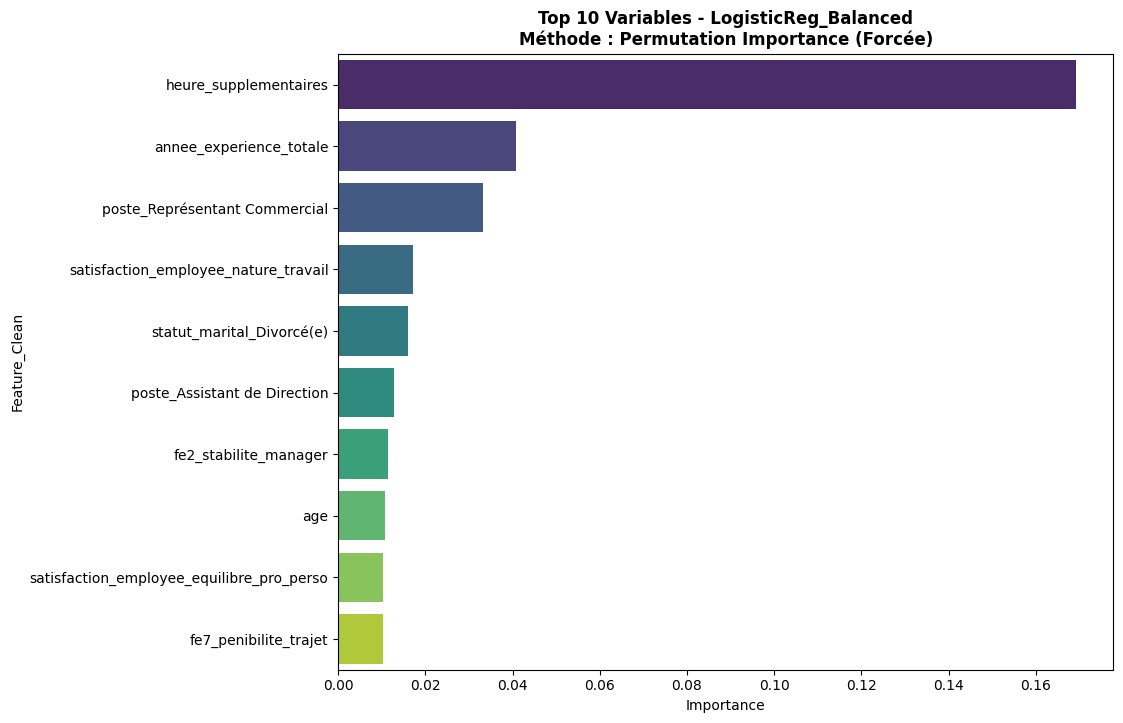

🏆 TOP 10 DES VARIABLES DÉTERMINANTES
----------------------------------------
1. heure_supplementaires (0.1693)
2. annee_experience_totale (0.0407)
3. poste_Représentant Commercial (0.0332)
4. satisfaction_employee_nature_travail (0.0170)
5. statut_marital_Divorcé(e) (0.0159)
6. poste_Assistant de Direction (0.0128)
7. fe2_stabilite_manager (0.0113)
8. age (0.0108)
9. satisfaction_employee_equilibre_pro_perso (0.0102)
10. fe7_penibilite_trajet (0.0102)
['n_std__heure_supplementaires', 'n_log__annee_experience_totale', 'c_ohe__poste_Représentant Commercial', 'n_std__satisfaction_employee_nature_travail', 'c_ohe__statut_marital_Divorcé(e)', 'c_ohe__poste_Assistant de Direction', 'fe2_stabilite_manager', 'n_std__age', 'n_std__satisfaction_employee_equilibre_pro_perso', 'fe7_penibilite_trajet']


In [11]:
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, fbeta_score

def analyser_importance_features_by_method(nom_modele=None, X=None, y=None, top_n=15, method='auto', scoring='f1'):
    """
    Analyse l'importance des variables avec priorité configurable.
    
    Arguments:
    ----------
    method : 'auto'       -> Utilise native si disponible, sinon permutation.
             'permutation'-> FORCE le calcul par permutation (idéal pour modèles linéaires).
             'native'     -> FORCE l'utilisation de coef_ ou feature_importances_.
    """
    # 1. Récupération du modèle (Logique inchangée)
    if nom_modele is None:
        nom, instance, res = modeler.obtenir_meilleur_modele()
    else:
        nom = nom_modele
        instance, res = modeler.obtenir_modele(nom)

    features = X.columns if X is not None else X_train.columns
    importances = None
    type_imp = ""

    # 2. Logique de décision (Modifiée pour donner la priorité à la méthode choisie)
    
    # CAS FORCE : PERMUTATION
    if method == 'permutation':
        if X is not None and y is not None:
            f2_scorer      = make_scorer(fbeta_score, beta=2, zero_division=0)
            actual_scoring = f2_scorer if scoring == 'f2' else scoring
            
            print(f"🔄 Calcul de la Permutation Importance ({scoring}) pour {nom}...")
            
            r = permutation_importance(
                instance, X, y, 
                n_repeats     = 3, 
                scoring       = actual_scoring, # Aquí pasamos el objeto f2_scorer o el string 'f1'
                random_state  = 42, 
                n_jobs        = -1
            )
            importances = r.importances_mean
            type_imp = "Permutation Importance (Forcée)"
        else:
            print("❌ Erreur: X et y sont requis pour la permutation.")
            return None

    # CAS NATIVE (ou AUTO si permutation n'est pas forcée)
    if importances is None:
        if hasattr(instance, 'feature_importances_') and method != 'permutation':
            importances = instance.feature_importances_
            type_imp = "Native (Gini/Gain)"
        elif hasattr(instance, 'coef_') and method != 'permutation':
            importances = np.abs(instance.coef_[0])
            type_imp = "Coefficients (Magnitude)"

    # 3. Finalisation (DataFrame et Plot)
    if importances is None:
        print(f"⚠️ Impossible d'extraire l'importance pour {nom} avec la méthode {method}")
        return None

    df_imp                  = pd.DataFrame({'Feature': features, 'Importance': importances})
    df_imp['Feature_Clean'] = df_imp['Feature'].str.replace(r'c_ohe__|n_std__|n_log__|__', ' ', regex=True).str.strip()
    df_imp                  = df_imp.sort_values(by='Importance', ascending=False).head(top_n)

    # Visualisation
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature_Clean', data=df_imp, palette='viridis')
    plt.title(f'Top {top_n} Variables - {nom}\nMéthode : {type_imp}', fontweight='bold')
    plt.show()

    return df_imp
# -----------------------------------------------------------------------------
# TEXTE

# Esto ignorará los coeficientes y calculará el impacto real en el set de Test
top_N_features = analyser_importance_features_by_method(
    X=X_test, 
    y=y_test, 
    top_n=10,
    scoring='f2',
    method='permutation'
)


print("🏆 TOP 10 DES VARIABLES DÉTERMINANTES")
print("-" * 40)
for i, row in enumerate(top_N_features.itertuples(), 1):
    print(f"{i}. {row.Feature_Clean} ({row.Importance:.4f})")

# Stocker la liste des noms pour plus tard
liste_top_10 = top_N_features['Feature'].tolist()

# -----------------------------------------------------------------------------
# GRAPHIQUE
# Exécution de l'analyse

print(list(top_N_features['Feature'].values))

In [12]:
# 1. Identificamos las variables vitales usando Permutación (Impacto en F2)
# 3. Ahora ya puedes llamar a la función normalmente

# 4. Extraer la lista de features para el siguiente paso
features_vitales = top_N_features['Feature'].tolist()

# 2. Creamos los sets "Light" basados en este impacto real
X_train_light = X_train[features_vitales]
X_test_light  = X_test[features_vitales]

# 3. Re-entrenamos el modelo para que SHAP trabaje sobre una base sólida y limpia
classifier_instance.fit(X_train_light, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

### 🔎🛠️ Recherche d’hyperparamètres pour fine-tuner le modèle


### 1. ENTRAÎNEMENT DU MODÈLE "LIGHT" (Version Simplifiée)

In [13]:
# On utilise uniquement les 26 variables sélectionnées
classifier_instance.fit(X_train_light, y_train)

# Prédictions
y_pred_light  = classifier_instance.predict(X_test_light)
y_proba_light = classifier_instance.predict_proba(X_test_light)[:, 1]

### 2. ANALYSE DES PERFORMANCES

In [14]:
from sklearn.metrics import roc_auc_score, recall_score, classification_report

# 1. Calcul des métriques pour le modèle "Light" (celui qui vient d'être entraîné)
auc_light    = roc_auc_score(y_test, y_proba_light)
rappel_light = recall_score(y_test, y_pred_light)

# 2. Affichage de la comparaison
print("=== COMPARAISON DES MODÈLES (Test Set) ===")
# On utilise 'roc_auc' et 'recall' tels qu'ils apparaissent dans ton dictionnaire
print(f"Modèle Complet   : {resultats_complets['scores_test']['roc_auc']:.3f} (AUC) | {resultats_complets['scores_test']['recall']:.3f} (Rappel)")
print(f"Modèle Simplifié : {auc_light:.3f} (AUC) | {rappel_light:.3f} (Rappel)")
print("-" * 50)

# 3. Rapport détaillé pour le modèle simplifié
print("\nDÉTAILS DU MODÈLE SIMPLIFIÉ :")
print(classification_report(y_test, y_pred_light))


=== COMPARAISON DES MODÈLES (Test Set) ===
Modèle Complet   : 0.803 (AUC) | 0.610 (Rappel)
Modèle Simplifié : 0.755 (AUC) | 0.644 (Rappel)
--------------------------------------------------

DÉTAILS DU MODÈLE SIMPLIFIÉ :
              precision    recall  f1-score   support

           0       0.92      0.77      0.84       309
           1       0.35      0.64      0.46        59

    accuracy                           0.75       368
   macro avg       0.64      0.71      0.65       368
weighted avg       0.83      0.75      0.78       368



### 3. VISUALISATION DU MODÈLE "LIGHT"

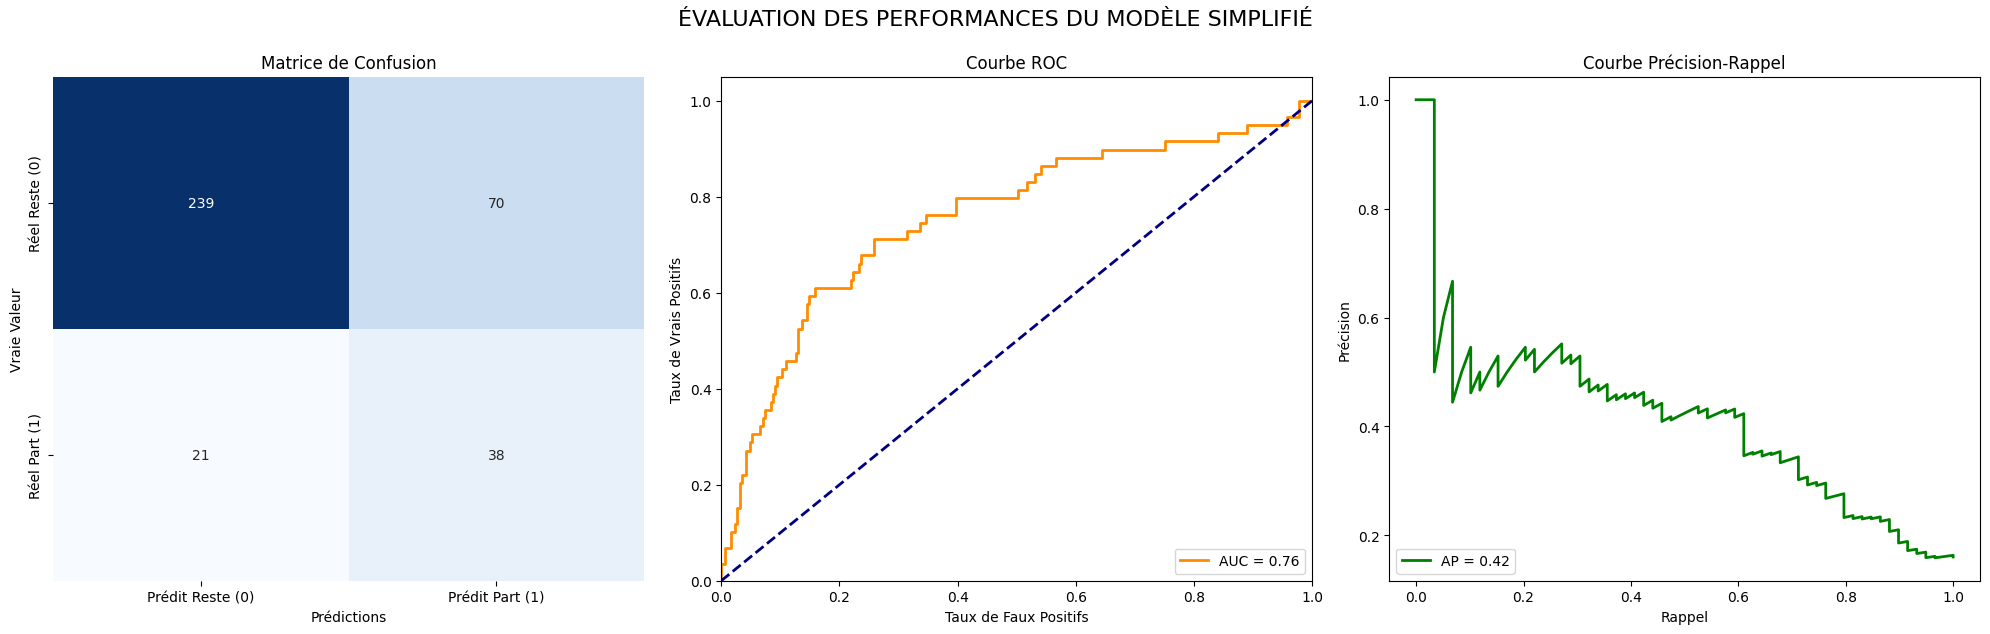

In [15]:

# Configuración de la figura con 3 sub-gráficos en una fila
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# =============================================================================
# 1. MATRICE DE CONFUSION
# =============================================================================
cm = confusion_matrix(y_test, y_pred_light)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Prédit Reste (0)', 'Prédit Part (1)'],
            yticklabels=['Réel Reste (0)', 'Réel Part (1)'], ax=axes[0])
axes[0].set_title("Matrice de Confusion")
axes[0].set_xlabel("Prédictions")
axes[0].set_ylabel("Vraie Valeur")

# =============================================================================
# 2. COURBE ROC (AUC)
# =============================================================================
fpr, tpr, _ = roc_curve(y_test, y_proba_light)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel("Taux de Faux Positifs")
axes[1].set_ylabel("Taux de Vrais Positifs")
axes[1].set_title("Courbe ROC")
axes[1].legend(loc="lower right")

# =============================================================================
# 3. COURBE PRÉCISION-RAPPEL (AP)
# =============================================================================
precision, rappel, _ = precision_recall_curve(y_test, y_proba_light)
ap = average_precision_score(y_test, y_proba_light)

axes[2].plot(rappel, precision, color='green', lw=2, label=f'AP = {ap:.2f}')
axes[2].set_xlabel("Rappel")
axes[2].set_ylabel("Précision")
axes[2].set_title("Courbe Précision-Rappel")
axes[2].legend(loc="lower left")

# Ajustar el diseño para que no se solapen
plt.tight_layout()
plt.suptitle("ÉVALUATION DES PERFORMANCES DU MODÈLE SIMPLIFIÉ", fontsize=16, y=1.05)
plt.show()


Comparative SANS FINE-TUNING (F2)

<div align="left">
  <img src="../docs/images/comparativa_sans_fine_tunning.png" width="1000px" alt="Logo TechNova Partners">
</div>

Comparative AVEC FINE-TUNING (F2)

<div align="left">
  <img src="../docs/images/comparativa_avec_fine_tunning.png" width="1000px" alt="Logo TechNova Partners">
</div>

| Métrique | Modèle avec Fine-Tuning (F2) | Modèle Original (Non optimisé) | Gagnant selon le contexte |
| --- | --- | --- | --- |
| **Rappel (Recall)** | **69.5%** () | 64.4% () | **F2 (Fine-Tuned)** |
| **Faux Négatifs** | **18** (Départs non détectés) | 21 | **F2 (Fine-Tuned)** |
| **Faux Positifs** | 82 (Fausses alertes) | **70** | **Original** |
| **AUC (ROC)** | 0.75 | **0.76** | **Original (de peu)** |
| **AP (PR Curve)** | 0.41 | **0.42** | **Original (de peu)** |


## 4. 📶 SHAP CONFIGURATION avec LinearExplainer

In [16]:
def obtenir_shap_explainer(modele, X_reference):
    """
    Détecte automatiquement le type de modèle et retourne le bon explainer SHAP.
    """
    # 1. Cas des modèles à base d'arbres (Random Forest, XGBoost, CatBoost, etc.)
    if hasattr(modele, "feature_importances_"):
        print("🌲 Modèle d'arbres détecté -> Utilisation de TreeExplainer")
        return shap.TreeExplainer(modele)
    
    # 2. Cas des modèles linéaires (Logistic Regression, Linear Regression)
    elif hasattr(modele, "coef_"):
        print("📈 Modèle linéaire détecté -> Utilisation de LinearExplainer")
        return shap.LinearExplainer(modele, X_reference)
    
    # 3. Cas général (S'adapte à tout mais beaucoup plus lent)
    else:
        print("🔮 Modèle complexe détecté -> Utilisation de KernelExplainer (Lent)")
        # On utilise un échantillon de la référence pour accélérer le calcul
        return shap.KernelExplainer(modele.predict_proba, shap.sample(X_reference, 50))

# --- UTILISATION ---
# On utilise X_train_light comme background pour la distribution des variables
explainer = obtenir_shap_explainer(classifier_instance, X_train_light)

# 2. Calcular los SHAP values para Train y Test
# SHAP calcula cuánto aporta cada variable a la probabilidad de que el empleado se vaya
shap_values_train = explainer(X_train_light)
shap_values_test  = explainer(X_test_light)

📈 Modèle linéaire détecté -> Utilisation de LinearExplainer


Voici la valeur de référence que SHAP utilsie pour le calcul des valeurs de Shapley

In [17]:
explainer.expected_value

np.float64(-0.5363383651108666)

In [18]:
# Asegúrate de que y_test sea numérico (0 y 1)
# Calculamos la diferencia absoluta entre la probabilidad y la realidad
absolute_errors_test = pd.Series(
    [abs(true - proba) for true, proba in zip(y_test, y_proba_light)]
)

print("--- Statistiques de l'erreur de probabilité (Clasificación) ---")
print(absolute_errors_test.describe().apply(lambda x: format(x, "f")))

--- Statistiques de l'erreur de probabilité (Clasificación) ---
count    368.000000
mean       0.373589
std        0.206325
min        0.031242
25%        0.209789
50%        0.328790
75%        0.496664
max        0.945256
dtype: object


In [19]:
# Ver todos los nombres de las variables
print(X_train_light.columns.tolist())

['n_std__heure_supplementaires', 'n_log__annee_experience_totale', 'c_ohe__poste_Représentant Commercial', 'n_std__satisfaction_employee_nature_travail', 'c_ohe__statut_marital_Divorcé(e)', 'c_ohe__poste_Assistant de Direction', 'fe2_stabilite_manager', 'n_std__age', 'n_std__satisfaction_employee_equilibre_pro_perso', 'fe7_penibilite_trajet']


## 5. Beeswarm plot

In [20]:
# 1. Calculer l'importance moyenne (moyenne des valeurs absolues de SHAP)
shap_importance = np.abs(shap_values_train.values).mean(0)

# 2. Créer un DataFrame pour organiser les résultats
importance_df = pd.DataFrame({
    'Feature': X_train_light.columns,
    'SHAP Importance': shap_importance
})

# 3. Trier par importance et afficher le Top 10
top_shap_list = importance_df.sort_values(by='SHAP Importance', ascending=False).head(10)

print("🏆 TOP 10 SHAP - IMPORTANCE GLOBALE MOYENNE")
print("-" * 45)
for i, row in top_shap_list.iterrows():
    print(f"{row['Feature']:<40} | {row['SHAP Importance']:.4f}")

🏆 TOP 10 SHAP - IMPORTANCE GLOBALE MOYENNE
---------------------------------------------
n_std__heure_supplementaires             | 0.5860
n_log__annee_experience_totale           | 0.3936
n_std__satisfaction_employee_nature_travail | 0.2953
c_ohe__poste_Assistant de Direction      | 0.2238
fe2_stabilite_manager                    | 0.1861
n_std__satisfaction_employee_equilibre_pro_perso | 0.1757
n_std__age                               | 0.1535
c_ohe__statut_marital_Divorcé(e)         | 0.1450
c_ohe__poste_Représentant Commercial     | 0.0507
fe7_penibilite_trajet                    | 0.0414


Importance Globale et Distribution (Beeswarm) :


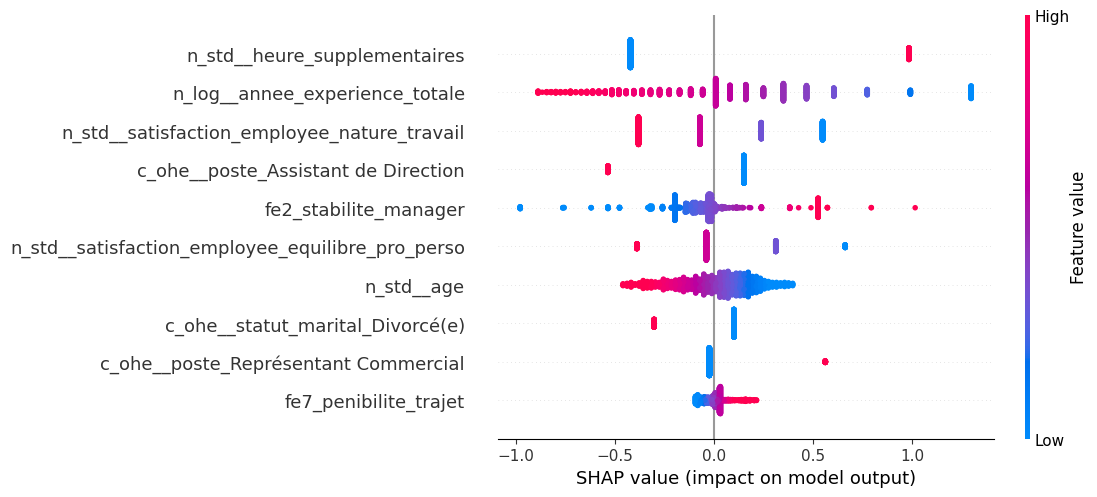

In [21]:
# Beeswarm plot : Importance GLOBALE et distribution des impacts
# C'est le graphique le plus puissant : il montre l'impact des variables sur l'ensemble du dataset
print("Importance Globale et Distribution (Beeswarm) :")
shap.plots.beeswarm(shap_values_train)

📈 Interprétation des variables clés (Vision Globale):

1. **n_std__heure_supplementaires :** * C'est votre prédicteur le plus puissant.
* Les points **rouges** (valeurs élevées) sont massivement à droite.
* *Interprétation :* Faire des heures supplémentaires est le facteur n°1 qui pousse les employés vers la sortie.

2. **n_log__annee_experience_totale :**
* Ici, les points **rouges** sont à gauche et les **bleus** à droite.
* *Interprétation :* Les profils juniors (peu d'expérience, bleu) ont un risque de départ beaucoup plus élevé. Les seniors (rouge) sont plus stables.

3. **n_log__annees_depuis_la_derniere_promotion :**
* Les points **rouges** sont à droite.
* *Interprétation :* Plus le temps passe sans promotion, plus le sentiment de stagnation augmente le risque d'attrition.

4. **n_std__satisfaction_employee_environnement / nature_travail / equipe :**
* Pour ces trois lignes, le bleu (basse satisfaction) est à droite.
* *Interprétation :* Sans surprise, une faible satisfaction dans n'importe quel domaine (environnement, équipe ou contenu du travail) est un moteur direct de départ.

5. **c_ohe__poste_Assistant de Direction :**
* On voit un point rouge très marqué à gauche.
* *Interprétation :* Ce poste spécifique semble extrêmement stable ; occuper cette fonction "protège" contre l'attrition dans ce dataset.

Le modèle a capturé des relations humaines logiques qui sont les <span style="color:red">piliers de l'attrition</span>: 

* <span style="color:red">l'épuisement (heures sup)</span>, 
* <span style="color:red">le manque d'évolution (promotion) </span>et 
* <span style="color:red">le manque d'expérience (juniors)</span> 


## 6. Generer SQL QUERY

In [24]:
def generar_sql_composite(df, max_weight=3.0):
    v_max  = df['SHAP Importance'].max()
    lineas = []
    
    for _, row in df.iterrows():
        peso = round((row['SHAP Importance'] / v_max) * max_weight, 2)
        clean_name = row['Feature'].split('__')[-1]
        
        # Usamos un marcador temporal ###
        if ' ' in clean_name or '(' in clean_name:
            safe_name = f"###{clean_name}###"
        else:
            safe_name = clean_name
        
        if 'satisfaction' in clean_name:
            lineas.append(f"((4 - {safe_name}) * {peso})")
        else:
            lineas.append(f"({safe_name} * {peso})")
    
    sql_formula = " + \n            ".join(lineas)
    
    # FORZAMOS el reemplazo del marcador por la comilla doble real (chr(34))
    resultado_final = sql_formula.replace("###", chr(34))
    
    return f"(\n            {resultado_final}\n        ) AS score_risque_composite"

In [25]:
cadena_sql = generar_sql_composite(top_shap_list)
print("--- COPY INTO QUERY SQL ---")
print(cadena_sql)

--- COPY INTO QUERY SQL ---
(
            (heure_supplementaires * 3.0) + 
            (annee_experience_totale * 2.01) + 
            ((4 - satisfaction_employee_nature_travail) * 1.51) + 
            ("poste_Assistant de Direction" * 1.15) + 
            (fe2_stabilite_manager * 0.95) + 
            ((4 - satisfaction_employee_equilibre_pro_perso) * 0.9) + 
            (age * 0.79) + 
            ("statut_marital_Divorcé(e)" * 0.74) + 
            ("poste_Représentant Commercial" * 0.26) + 
            (fe7_penibilite_trajet * 0.21)
        ) AS score_risque_composite


### Script de Diagnostic : Alignement des Caractéristiques

In [26]:
# 1. Obtenir les noms des variables (features) réellement utilisées par le modèle
# Si vous avez utilisé un Pipeline sklearn avec des transformations :
try:
    feature_names = classifier_instance.feature_names_in_
except AttributeError:
    # Si le modèle n'a pas enregistré les noms, on utilise les colonnes de X_train
    feature_names = X_train.columns

# 2. Extraire les coefficients du modèle
coeffs = classifier_instance.coef_[0]

# 3. Diagnostic rapide des dimensions
print(f"Nombre de variables : {len(feature_names)}")
print(f"Nombre de coefficients : {len(coeffs)}")

# 4. Création du DataFrame uniquement si les longueurs correspondent
if len(feature_names) == len(coeffs):
    df_coef = pd.DataFrame({
        'Variable': feature_names, 
        'Coefficient': coeffs
    }).sort_values(by='Coefficient', ascending=False)
    print(df_coef)
else:
    print("❌ Erreur de dimension ! Vérifiez si un encodeur (ex: OneHotEncoder) "
          "a augmenté le nombre de colonnes par rapport à X_train original.")

Nombre de variables : 10
Nombre de coefficients : 10
                                           Variable  Coefficient
0                      n_std__heure_supplementaires     0.632682
2              c_ohe__poste_Représentant Commercial     0.584720
6                             fe2_stabilite_manager     0.085580
9                             fe7_penibilite_trajet     0.055883
7                                        n_std__age    -0.186028
8  n_std__satisfaction_employee_equilibre_pro_perso    -0.247264
3       n_std__satisfaction_employee_nature_travail    -0.341227
4                  c_ohe__statut_marital_Divorcé(e)    -0.402625
1                    n_log__annee_experience_totale    -0.515835
5               c_ohe__poste_Assistant de Direction    -0.686084


# 🎓 Step 2. Feature Importance Local

## Waterfall plot sur Employé 0 (Train)

Analyse individuelle - Employé 0 (Train) :


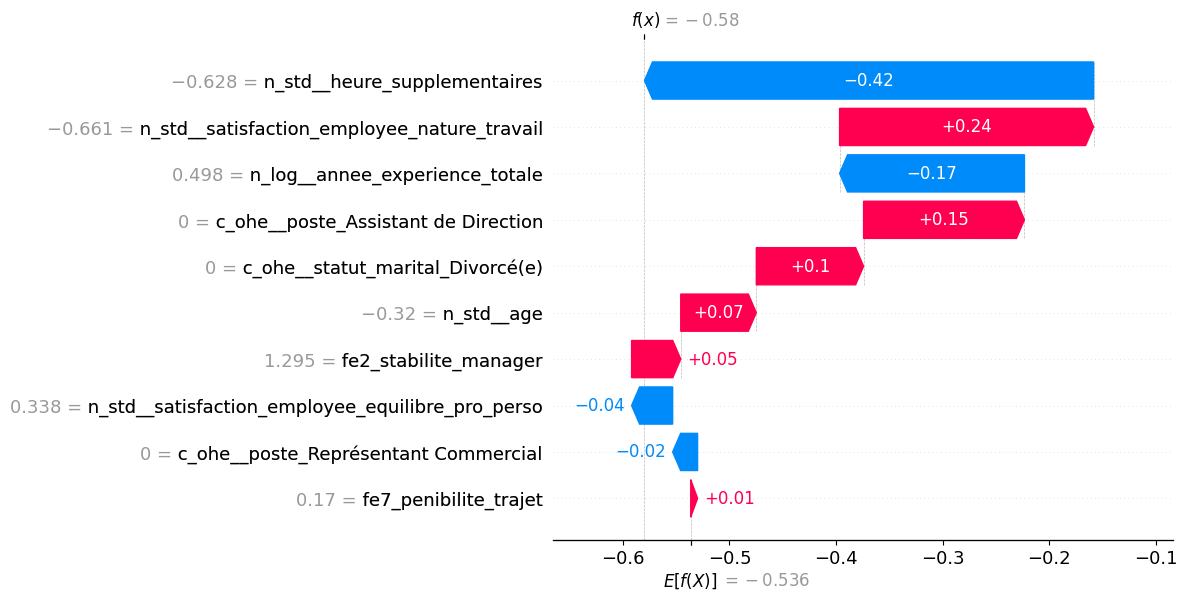

In [27]:
# Waterfall plot : Explication pour UN employé spécifique (ex: le premier du jeu d'entraînement)
# Ce graphique montre quels facteurs ont poussé CET employé vers le départ (1) ou la rétention (0)
print("Analyse individuelle - Employé 0 (Train) :")
shap.plots.waterfall(shap_values_train[0])

## Waterfall plot sur Employé 0 (Test)

Analyse individuelle - Employé 5 (Test):


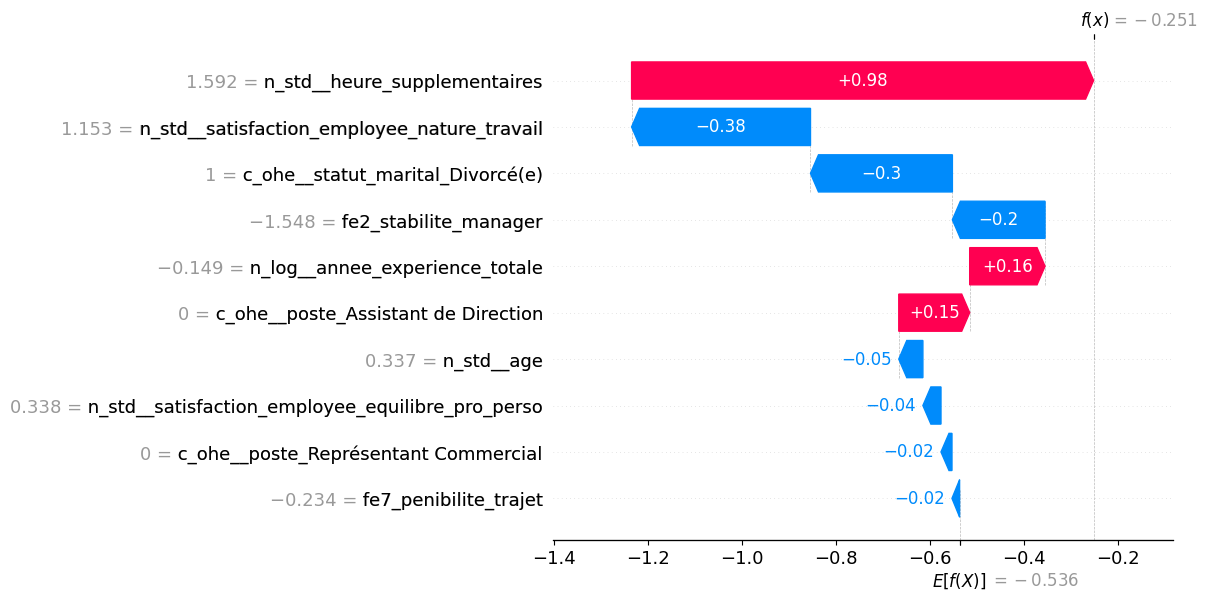

In [28]:
# Waterfall plot: Otro empleado del test (ej: el índice 5)
print("Analyse individuelle - Employé 5 (Test):")
shap.plots.waterfall(shap_values_test[5])

## Waterfall plot ANALYSE DES FACTEURS LOCAUX (TOP 5 RISQUES)

🔍 ANALYSE DES FACTEURS LOCAUX (TOP 5 RISQUES)
--------------------------------------------------

👤 Employé ID: 911 | Risque: Très Élevé


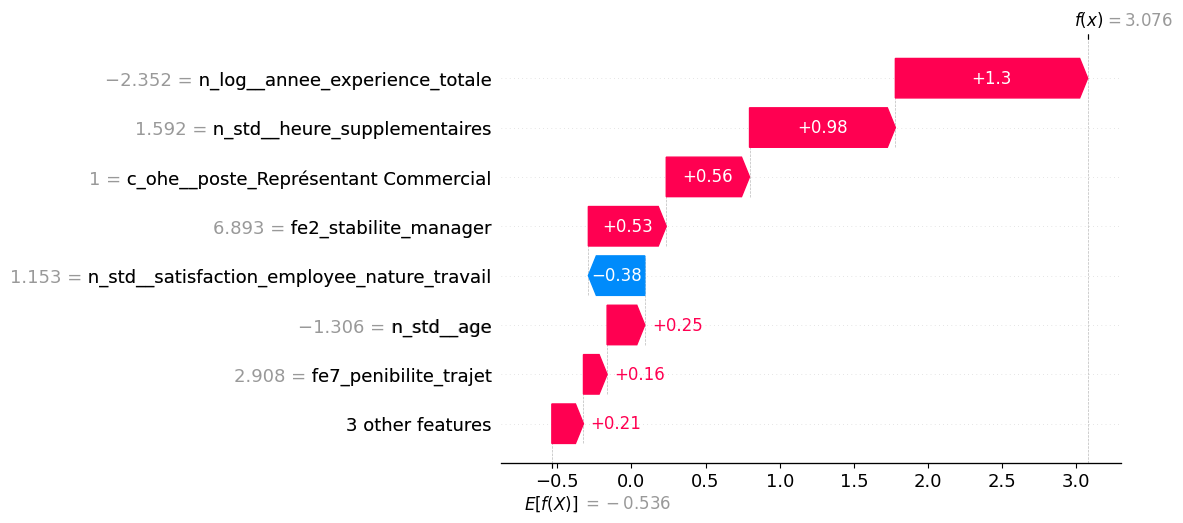


👤 Employé ID: 1379 | Risque: Très Élevé


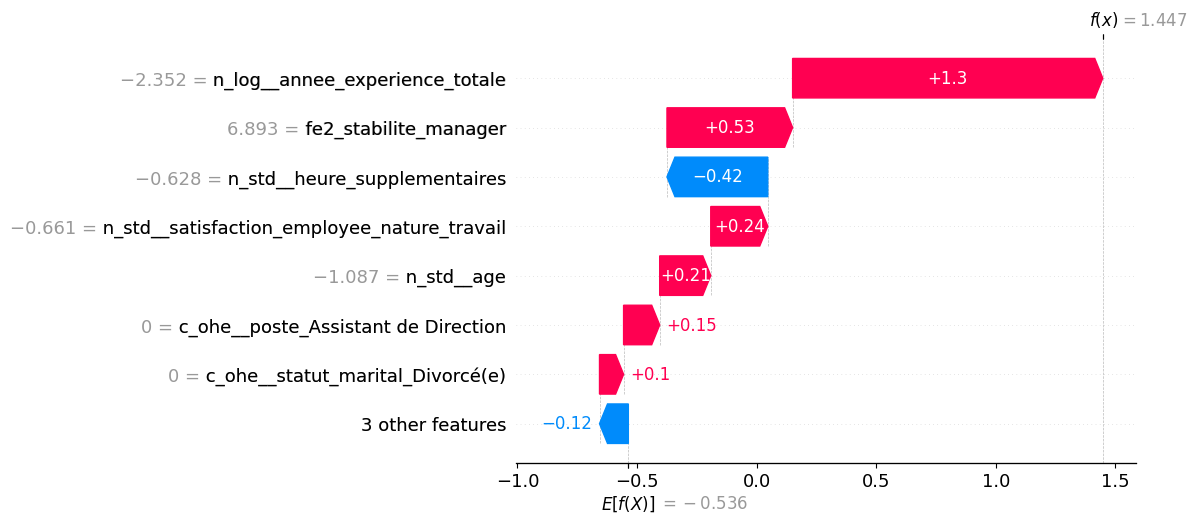


👤 Employé ID: 357 | Risque: Très Élevé


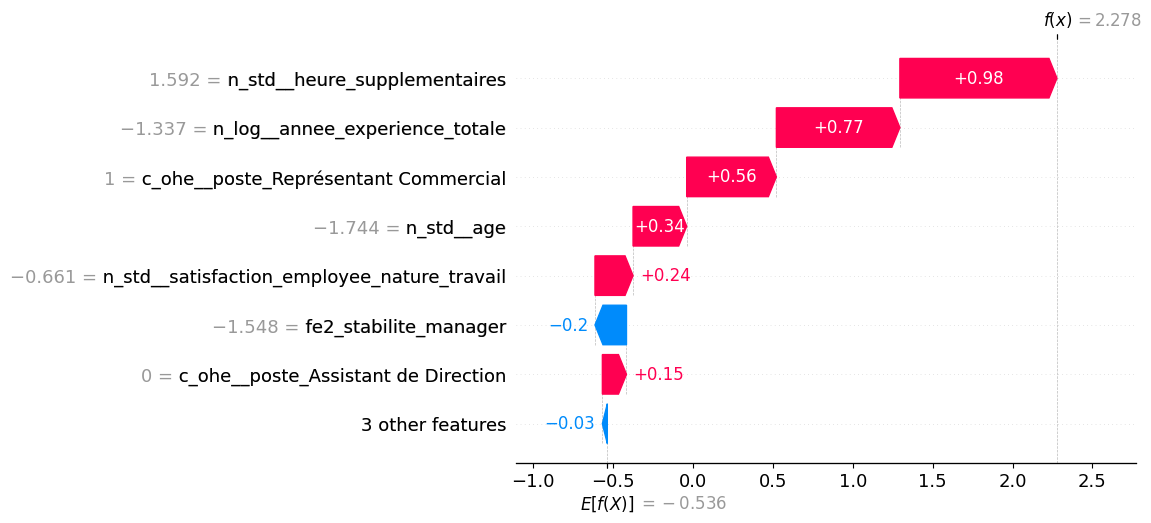


👤 Employé ID: 688 | Risque: Très Élevé


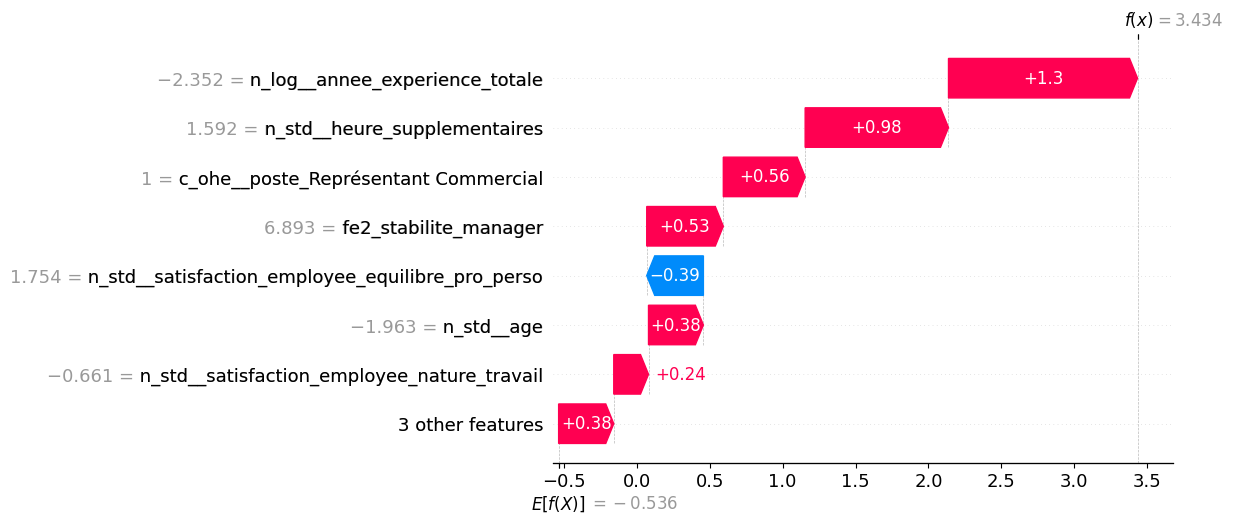


👤 Employé ID: 689 | Risque: Très Élevé


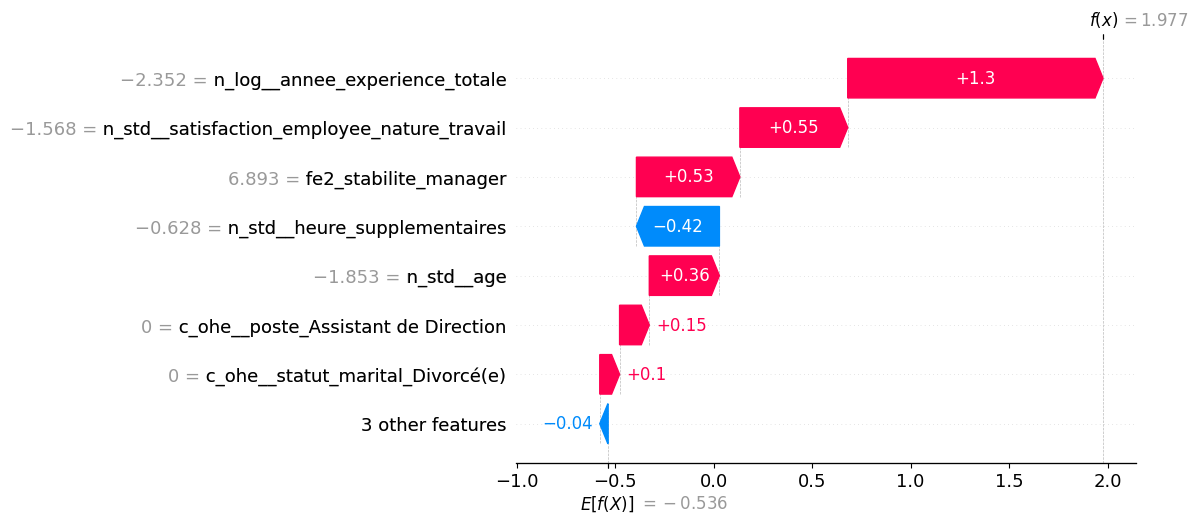

In [29]:
# On définit la liste des indices cibles (les 5 premiers de ta liste)
top_5_indices = [911, 1379, 357, 688, 689]

print("🔍 ANALYSE DES FACTEURS LOCAUX (TOP 5 RISQUES)")
print("-" * 50)

for idx in top_5_indices:
    # 1. Trouver la position de l'ID dans le DataFrame original pour extraire le SHAP value
    # Si tes données sont dans le set de test :
    try:
        # On récupère la position entière (integer location) de l'index dans le set de test
        pos = X_test_light.index.get_loc(idx)
        
        print(f"\n👤 Employé ID: {idx} | Risque: Très Élevé")
        
        # 2. Affichage du Waterfall plot pour cet individu précis
        # Cela montre quelles variables ont le plus contribué à sa probabilité de départ
        shap.plots.waterfall(shap_values_test[pos], max_display=8)
        
    except KeyError:
        print(f"⚠️ L'ID {idx} n'a pas été trouvé dans le set de test (vérifiez s'il est dans le train).")

## Dependency Plot. ANALYSER le sens des Shapley 

In [30]:
print(shap_values_test.feature_names)

['n_std__heure_supplementaires', 'n_log__annee_experience_totale', 'c_ohe__poste_Représentant Commercial', 'n_std__satisfaction_employee_nature_travail', 'c_ohe__statut_marital_Divorcé(e)', 'c_ohe__poste_Assistant de Direction', 'fe2_stabilite_manager', 'n_std__age', 'n_std__satisfaction_employee_equilibre_pro_perso', 'fe7_penibilite_trajet']


**Explication Générique du SHAP Dependency Plot** 
Analyse des interactions et de la contribution marginale

Le Dependency Plot ci-dessous permet d'interpréter la relation entre une variable spécifique et son impact sur la prédiction (valeurs de SHAP), tout en intégrant une troisième dimension via une coloration automatique. Cette approche permet de détecter des tendances de comportement plus complexes et granulaires que le graphique Beeswarm.

1. **Analyse de la tendance principale** : Le graphique illustre la dispersion des valeurs de SHAP par rapport aux valeurs réelles de la variable étudiée.

* Une tendance **ascendante (ou descendante)** indique une influence directe de la feature sur la sortie du modèle.
    * Si cette relation apparaît **alinéaire**a, cela confirme que des valeurs plus élevées de la variable sont systématiquement associées à une augmentation (ou diminution) du score prédit, **avalidant ainsi la cohérence métier du modèle**a.

3. **Analyse des interactions (Coloration)** : La coloration révèle comment une seconde variable module l'impact de la première.

* Si des **groupes de couleurs distincts** apparaissent (par exemple, des points rouges concentrés sur une pente plus forte), nous identifions une **interaction non-linéaire** : _l'effet de la variable principale dépend alors du contexte fourni par la variable colorée_.
* À l'inverse, une **coloration homogène** suggère que la corrélation est purement numérique et ne reflète pas de synergie métier particulière.

5. **Détection des anomalies et limites** : La présence d'observations s'écartant de la tendance principale (valeurs SHAP inversées) peut signaler des outliers ou l'influence prédominante d'autres variables non visualisées ici. C'est la limite intrinsèque de ce graphique : il isole deux dimensions en supposant les autres constantes (ceteris paribus). Les corrélations latentes avec le reste du dataset ne doivent donc jamais être ignorées lors de l'interprétation finale.

📊 Analyse d'interaction : Heures Supplémentaires vs Satisfaction equilibre_pro_perso


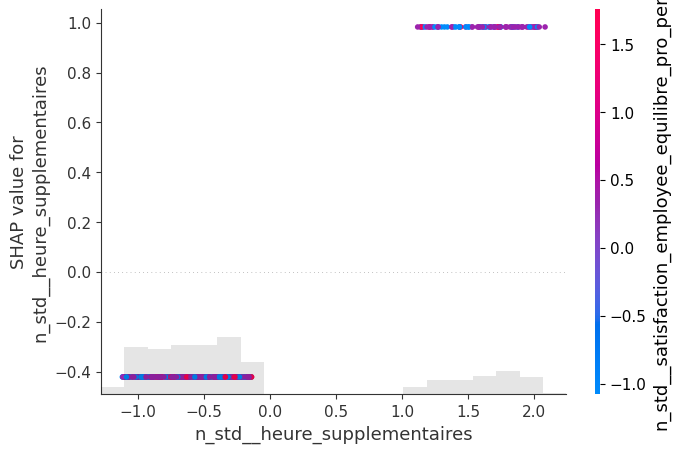

📊 Analyse d'interaction : Expérience vs n_std__age


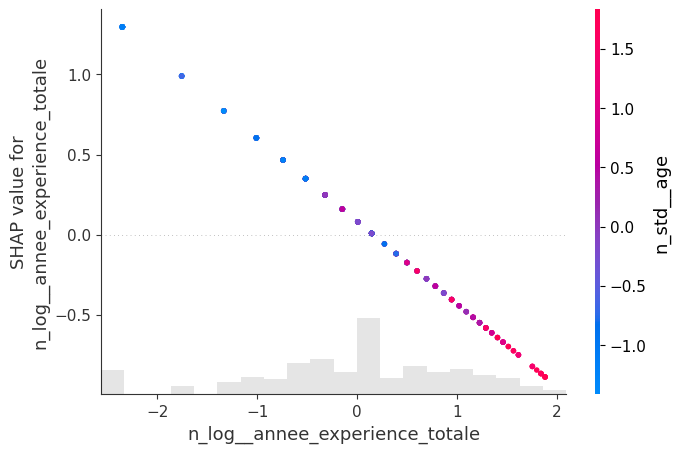

In [31]:
import shap

# 1. Analyse de l'impact des Heures Supplémentaires
# On regarde comment la satisfaction environnementale influence l'impact des heures sup
print("📊 Analyse d'interaction : Heures Supplémentaires vs Satisfaction equilibre_pro_perso")
shap.plots.scatter(shap_values_test[:, "n_std__heure_supplementaires"], 
                   color=shap_values_test[:, "n_std__satisfaction_employee_equilibre_pro_perso"])

# 2. Analyse de l'ancienneté avec l'âge ou les promotions
print("📊 Analyse d'interaction : Expérience vs n_std__age")
shap.plots.scatter(shap_values_test[:, "n_log__annee_experience_totale"], 
                   color=shap_values_test[:, "n_std__age"])

Analyse des Interactions (Scatter Plots)

Ces graphiques révèlent comment deux variables se combinent de manière **linéaire** ou **non-linéaire**.

**A. Heures Supplémentaires vs Équilibre Pro/Perso**

* **Comportement binaire :** Le graphique montre deux blocs distincts. On voit un "saut" brutal de l'impact SHAP (de -0.4 à +1.0).
* **Interprétation :** Le risque ne monte pas graduellement ; il y a un **seuil critique** (autour de 1.0 en valeur standardisée). L'interaction avec la satisfaction (couleurs mélangées dans les blocs) suggère que la charge de travail est le déclencheur principal, peu importe le niveau de satisfaction initial sur ce segment.

**B. Expérience vs Âge**

* **Relation Linéaire Décroissante :** Contrairement au premier, ce graphique montre une relation presque parfaitement linéaire.
* **Interprétation :** Chaque unité d'expérience supplémentaire réduit de façon constante le risque de départ.
* **Interaction :** La couleur (Âge) suit la pente. Cela confirme une forte corrélation : les employés les plus âgés (rouge) sont aussi ceux qui ont le plus d'expérience, et ce sont les profils les plus stables de l'entreprise.


**Sans forcer le couleur**

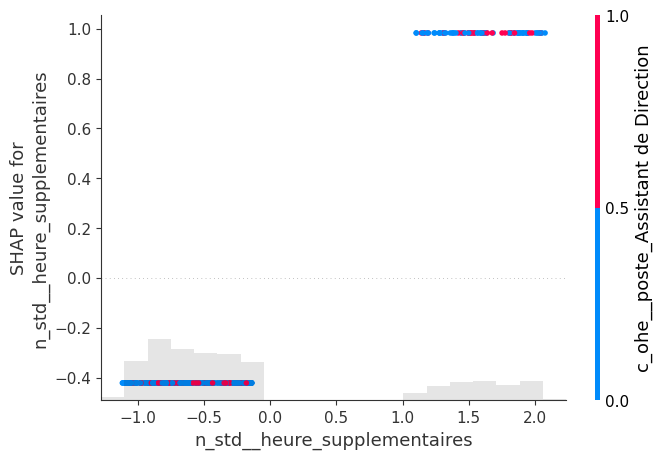

In [32]:
shap.plots.scatter(shap_values_test[:, "n_std__heure_supplementaires"], color=shap_values_test)

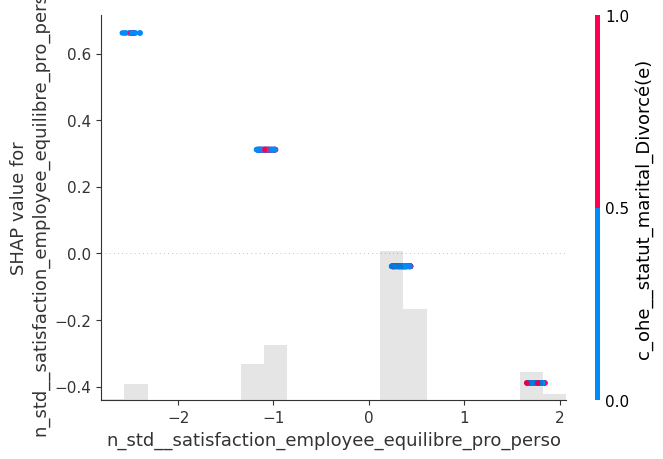

In [33]:
shap.plots.scatter(shap_values_test[:, "n_std__satisfaction_employee_equilibre_pro_perso"], color=shap_values_test)

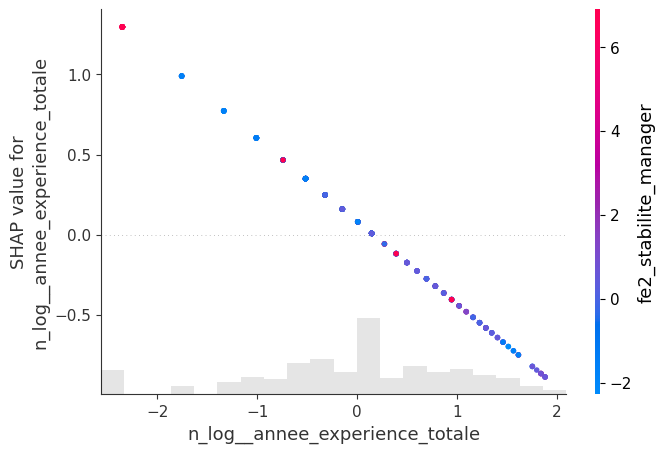

In [34]:
shap.plots.scatter(shap_values_test[:, "n_log__annee_experience_totale"], color=shap_values_test)

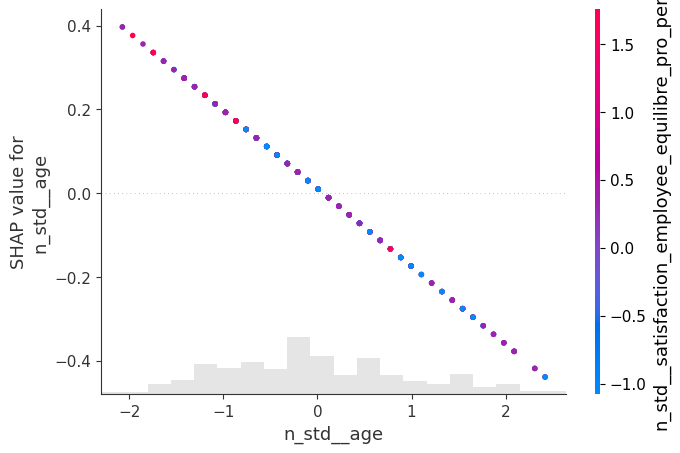

In [35]:
shap.plots.scatter(shap_values_test[:, "n_std__age"], color=shap_values_test)

# 🎯 Step 3. Recommandation Stratégique pour le departementde RH

📋 Recommandation Stratégique : "Le Plan des 3 P"

1. **Prévention de l'Épuisement (Priorité Haute)**

* **Action :** Mettre en place une alerte RH automatique dès qu'un employé dépasse un certain seuil d'heures supplémentaires sur deux mois consécutifs.
* **Justification :** Le graphique *Scatter* montre que le passage aux heures supplémentaires fait bondir le risque de départ de façon spectaculaire (SHAP value de -0.5 à +1.1). C'est le signal le plus prédictif du dataset.

2. **Parcours de Carrière et Promotion**

* **Action :** Créer des "points de carrière" obligatoires pour tous les employés n'ayant pas eu de promotion depuis plus de 2 ans.
* **Justification :** Le *Beeswarm* indique que la stagnation (points rouges sur `annees_depuis_la_derniere_promotion`) est un moteur de départ majeur. Une simple reconnaissance ou une évolution de poste peut neutraliser ce risque.

3. **Protection des Talents Juniors**

* **Action :** Lancer un programme de mentorat spécifique pour les employés ayant moins de 5 ans d'expérience totale.
* **Justification :** Le modèle révèle une vulnérabilité critique chez les profils peu expérimentés (points bleus à droite sur l'axe de l'expérience). L'accompagnement senior est le meilleur antidote à ce risque "structurel".
